Mateen Shagagi

The dataset I used for this notebook is the link below. The meanings for each music metric are found in the description for this dataset.
https://www.kaggle.com/datasets/salvatorerastelli/spotify-and-youtube

Import relevant modules.

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import StrMethodFormatter

Read data from the file Spotify_Youtube.csv.csv into a DataFrame.
Then print the number of rows and columns of the DataFrame and print the first 2 rows to observe what our data looks like.

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('Spotify_Youtube.csv')
print(df.shape)
df.head(2)

(20718, 28)


,Unnamed: 0,Artist,Url_spotify,Track,Album,Album_type,Uri,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Url_youtube,Title,Channel,Views,Likes,Comments,Description,Licensed,official_video,Stream
0,0,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Feel Good Inc.,Demon Days,album,spotify:track:0d28khcov6AiegSCpG5TuT,0.818,0.705,6.0,-6.679,0.1770,0.00836,0.002330,0.6130,0.772,138.559,222640.0,https://www.youtube.com/watch?v=HyHNuVaZJ-k,Gorillaz - Feel Good Inc. (Official Video),Gorillaz,693555221.0,6220896.0,169907.0,Official HD Video for Gorillaz' fantastic trac...,True,True,1.040235e+09
1,1,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Rhinestone Eyes,Plastic Beach,album,spotify:track:1foMv2HQwfQ2vntFf9HFeG,0.676,0.703,8.0,-5.815,0.0302,0.08690,0.000687,0.0463,0.852,92.761,200173.0,https://www.youtube.com/watch?v=yYDmaexVHic,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Gorillaz,72011645.0,1079128.0,31003.0,The official video for Gorillaz - Rhinestone E...,True,True,3.100837e+08


Drop irrelevant columns that won't contribute to our album ranking or success model.

In [3]:
df = df.drop(columns=['Unnamed: 0','Url_spotify', 'Uri', 'Duration_ms', 'Url_youtube', 'Title', 'Channel', 'Comments', 'Description', 'Licensed', 'official_video'])
df.head(5)

,Artist,Track,Album,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Views,Likes,Stream
0,Gorillaz,Feel Good Inc.,Demon Days,album,0.818,0.705,6.0,-6.679,0.1770,0.008360,0.002330,0.6130,0.772,138.559,693555221.0,6220896.0,1.040235e+09
1,Gorillaz,Rhinestone Eyes,Plastic Beach,album,0.676,0.703,8.0,-5.815,0.0302,0.086900,0.000687,0.0463,0.852,92.761,72011645.0,1079128.0,3.100837e+08
2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),single,0.695,0.923,1.0,-3.930,0.0522,0.042500,0.046900,0.1160,0.551,108.014,8435055.0,282142.0,6.306347e+07
3,Gorillaz,On Melancholy Hill,Plastic Beach,album,0.689,0.739,2.0,-5.810,0.0260,0.000015,0.509000,0.0640,0.578,120.423,211754952.0,1788577.0,4.346636e+08
4,Gorillaz,Clint Eastwood,Gorillaz,album,0.663,0.694,10.0,-8.627,0.1710,0.025300,0.000000,0.0698,0.525,167.953,618480958.0,6197318.0,6.172597e+08


Check for any NaN values in our Dataframe.

In [4]:
df.isna().sum()

Artist                0
Track                 0
Album                 0
Album_type            0
Danceability          2
Energy                2
Key                   2
Loudness              2
Speechiness           2
Acousticness          2
Instrumentalness      2
Liveness              2
Valence               2
Tempo                 2
Views               470
Likes               541
Stream              576
dtype: int64

Cleaning the data:

Since we don't want our model to run into any errors, drop the rows with NaN values.

Furthermore, for the sake of readability and knowing the songs we are working with, keep only the Latin based alphabet songs.

Sort df based on Spotify streams, drop duplicate songs if they have the same track name and album name, keep the first (the one with more streams).

In [5]:
df = df.dropna()

df = df[~df.Track.str.contains(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]')]
df = df[~df.Album.str.contains(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]')]

df = df.sort_values('Stream', ascending=False).drop_duplicates(subset=['Track', 'Album'], keep='first').sort_index()
print(df.shape)

(17571, 17)


# Album Comparison

Create a new dataframe from our existing one that only includes songs that are a part of an album.

Print the top 5 albums based on Spotify streams.

In [6]:
df2 = df[df['Album_type'] == 'album']

albums = df2.groupby('Album')[['Stream']].sum()
albums_sorted = albums.sort_values(['Stream'], ascending=False)
albums_sorted.head()

,Stream
Album,
SOUR,8.325355e+09
Hollywood's Bleeding,6.954563e+09
÷ (Deluxe),6.835601e+09
Un Verano Sin Ti,6.464799e+09
?,5.824181e+09


Create a bar plot displaying the top ten albums (based on the average value) for each music metric.

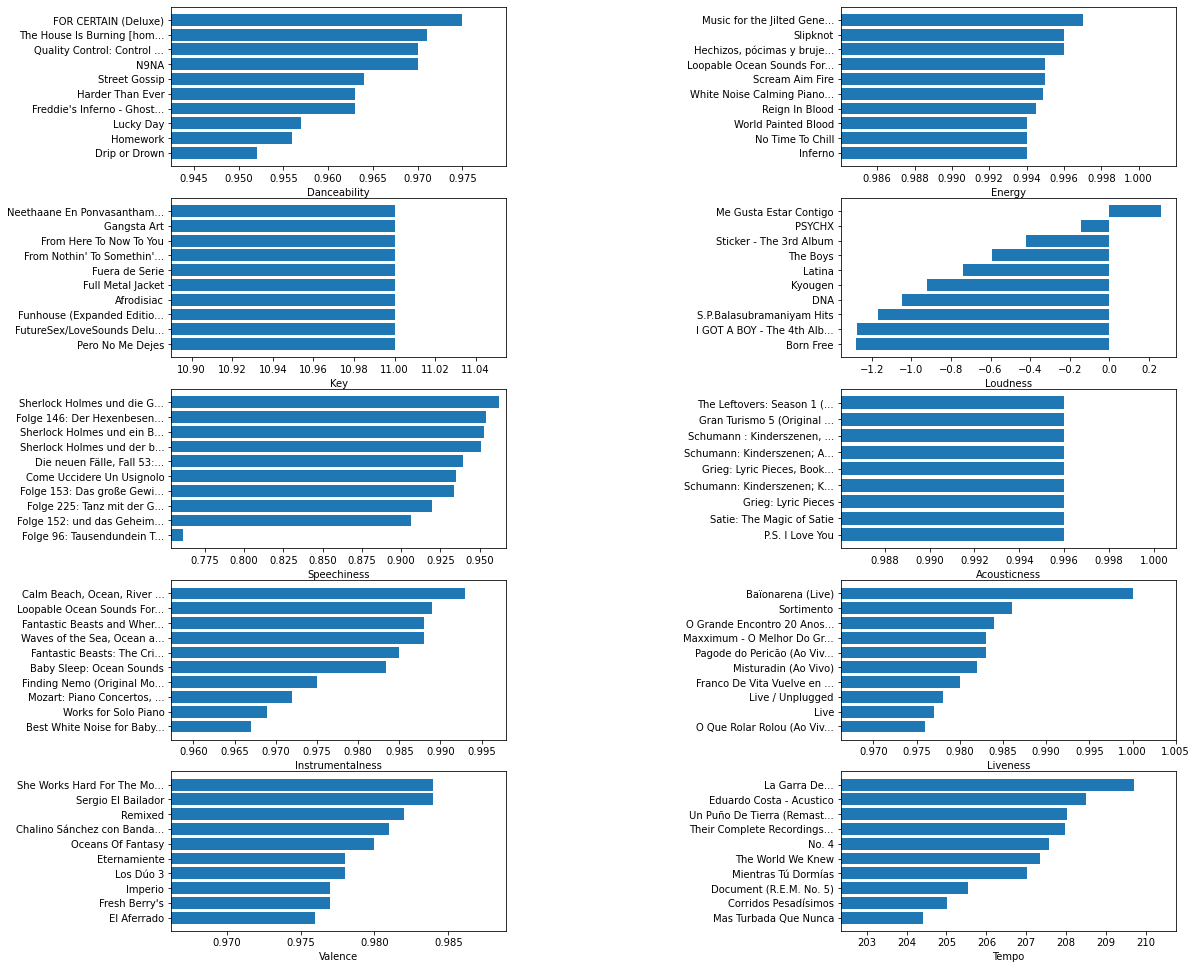

In [7]:
fig = plt.figure(figsize=(18,17))
plt.rcParams["font.size"] = 10
plt.subplots_adjust(wspace = 1)

headers = [['Danceability', 'Energy'],
           ['Key', 'Loudness'],
           ['Speechiness', 'Acousticness'],
           ['Instrumentalness', 'Liveness'],
           ['Valence', 'Tempo']]
count = 1
for header_list in headers:
    for header in header_list:
        plt.subplot(5,2,count)
        albums = df2.groupby('Album')[[header]].mean()
        albums_sorted = albums.sort_values([header], ascending=False)[:10][::-1]
        top_albums = albums_sorted.index.tolist()
        
        top_albums = [f'{album[:25]}...' if len(album) > 25 else album for album in top_albums]
        
        plt.barh(top_albums, albums_sorted[header])
        
        if header != 'Loudness':
            plt.xlim([albums_sorted[header].min()*0.99, albums_sorted[header].max() * 1.005])
        
        plt.xlabel(header)
        count += 1

# Succesfull Song Similarities

Drop all unneccessary columns and create a new dataframe so we don't modify the original. We will need to use the song tracks later on.

In [8]:
df2 = df.drop(columns=['Artist', 'Track', 'Album', 'Album_type', 'Likes']).copy()
df2

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Views,Stream
0,0.818,0.705,6.0,-6.679,0.1770,0.008360,0.002330,0.6130,0.7720,138.559,693555221.0,1.040235e+09
1,0.676,0.703,8.0,-5.815,0.0302,0.086900,0.000687,0.0463,0.8520,92.761,72011645.0,3.100837e+08
3,0.689,0.739,2.0,-5.810,0.0260,0.000015,0.509000,0.0640,0.5780,120.423,211754952.0,4.346636e+08
4,0.663,0.694,10.0,-8.627,0.1710,0.025300,0.000000,0.0698,0.5250,167.953,618480958.0,6.172597e+08
5,0.760,0.891,11.0,-5.852,0.0372,0.022900,0.086900,0.2980,0.9660,120.264,259021161.0,3.238503e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
20713,0.582,0.926,5.0,-6.344,0.0328,0.448000,0.000000,0.0839,0.6580,90.002,71678.0,9.227144e+06
20714,0.531,0.936,4.0,-1.786,0.1370,0.028000,0.000000,0.0923,0.6570,174.869,164741.0,1.089818e+07
20715,0.443,0.830,4.0,-4.679,0.0647,0.024300,0.000000,0.1540,0.4190,168.388,35646.0,6.226110e+06
20716,0.417,0.767,9.0,-4.004,0.4190,0.356000,0.018400,0.1080,0.5390,155.378,6533.0,6.873961e+06


Create a plot to see the distribution and correlation of all the features.

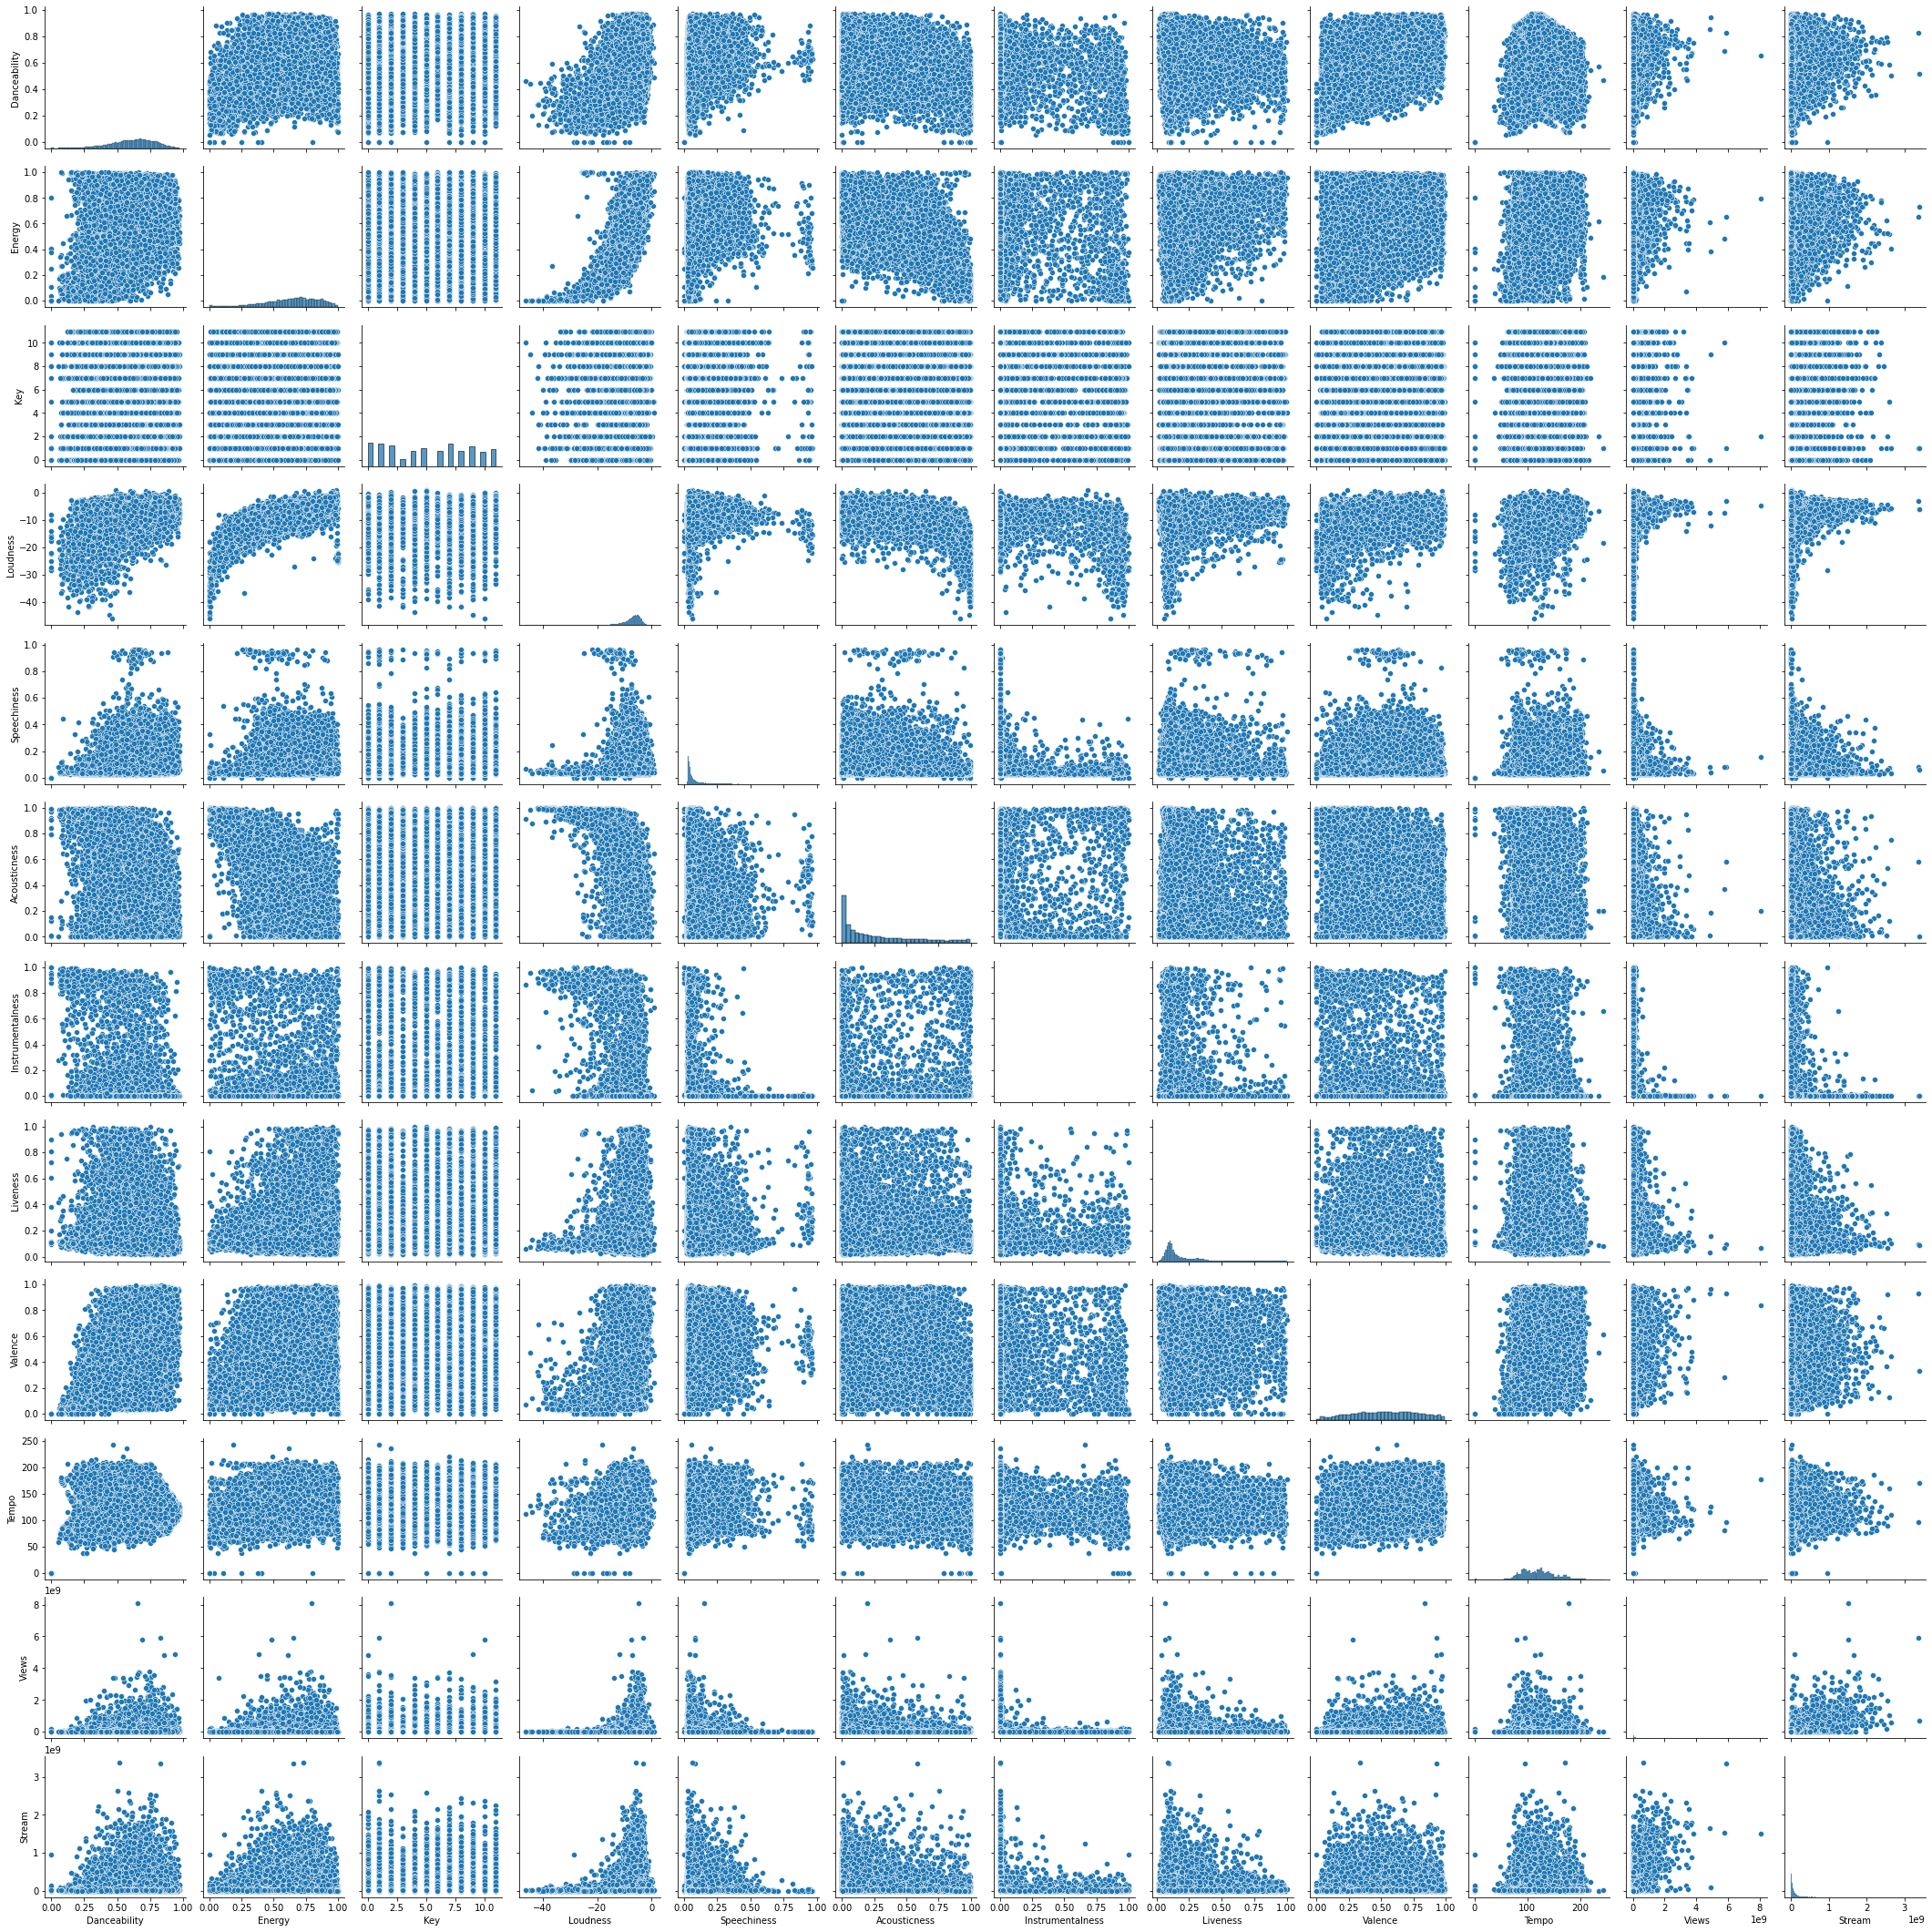

In [9]:
sns.pairplot(df2)

New feature: Seaborn Heatmap

A heatmap is a plot of rectangular data as a color-encoded matrix. I used a heatmap to show the correlation between all of the features in the dataset to easily see which metric has an effect on others.

Link to example: https://pythonbasics.org/seaborn-heatmap/

<AxesSubplot:>

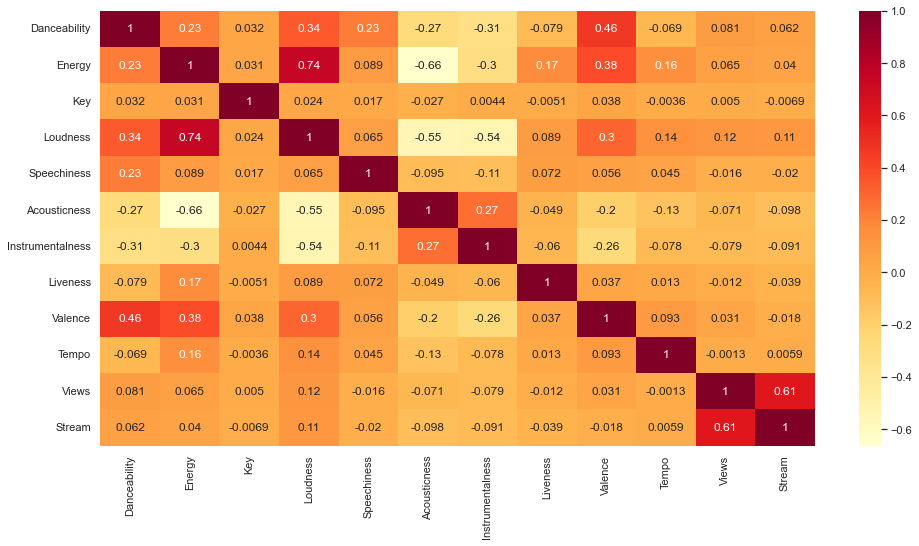

In [10]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = df2.corr()
sns.heatmap(corr,annot=True, cmap="YlOrRd")

The sklearn K-means model by default uses Euclidean distance to determine clusters. So, in order to have a more accurate clustering we scale the data so that all of the data are between 0 and 1.

In [11]:
scaler = MinMaxScaler()
df2[['Loudness', 'Tempo']] = scaler.fit_transform(df2[['Loudness', 'Tempo']])

For our first clustering, we want to find hidden patterns within the top 500 streamed songs on Spotify to determine similar characeristics in popular songs.

To figure out what part of the data has a lot of variation, we can use pandas var function to assign a variation score to each column, the lower the score the lower the variation the column has. To create a more spaced out clustering, remove the columns with a low variation.

Furthermore, remove the Streams and Views column as we want our clutsters to depend on them as we already are sorting by streams.

In [12]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
X = df2.sort_values('Stream', ascending=False)[:500]
print(X.var(axis=0))
X = X.drop(columns=['Key','Stream', 'Views', 'Loudness', 'Instrumentalness', 'Speechiness', 'Tempo', 'Liveness']).copy()

Danceability                        0.021
Energy                              0.031
Key                                13.655
Loudness                            0.003
Speechiness                         0.007
Acousticness                        0.059
Instrumentalness                    0.004
Liveness                            0.019
Valence                             0.051
Tempo                               0.012
Views              811013362331648640.000
Stream             154836780605199616.000
dtype: float64


Find the optimal number of clusters by plotting the WCSS (Within-Cluster Sum of Square) by cluster size and determining the elbow point.

[Text(0.5, 0, 'Cluster Size'), Text(0, 0.5, 'WCSS')]

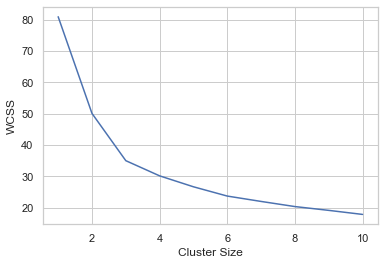

In [13]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
pd.DataFrame(wcss, index=range(1, 11)).plot(legend=False).set(xlabel="Cluster Size", ylabel="WCSS")

Using the elbow curve, we can determine the optimum number of clusters. We want to balance the amount of error and the potential of overfitting and in this case, the value k=3 is the best infection point.

Use our k value, initialize a kmeans model and make our predictions.

In [14]:
kmeans = KMeans(n_clusters=3,init='k-means++')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Assign a cluster column to our X dataframe so we can intrepret the clusters and map the cluster back to the customer data.

In [15]:
X['cluster'] = y_kmeans
clusters = X.groupby('cluster').agg('mean')
clusters

,Danceability,Energy,Acousticness,Valence
cluster,,,,
0,0.700,0.751,0.115,0.712
1,0.634,0.632,0.129,0.351
2,0.576,0.399,0.709,0.329


Use a bar plot to visualize our clusters and their differences.

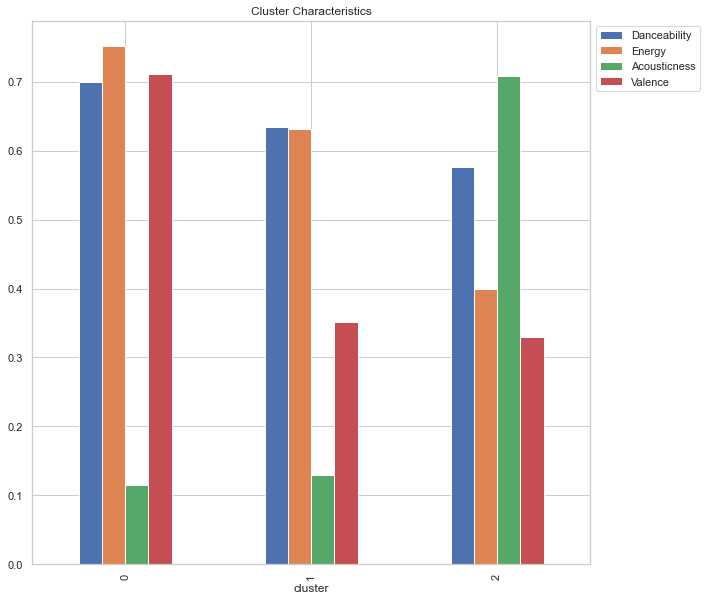

In [16]:
clusters.plot(kind='bar', figsize=(10,10))
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

As you can see above, there are 3 main clusters formed in the top 500 songs on Spotify.
Cluster 0's songs are high enery, high dancing, and high valence signifying happy pop songs.
Cluster 1's songs are high in energy and high in dancing by lower in valence signifying the more emotional but intense songs.
Cluster 2's songs are lower in energy and dancing but much higher in acousticness signifiying the country/indie/pop rock songs.

Since the other metrics have low variance, the average value can be taken to figure out more information about these successful songs.

These songs are on the louder side, not speechy (more singing/rapping than talking), not instrumental, not live, and have a medium speed tempo. 

In [17]:
df2.sort_values('Stream', ascending=False)[:500].describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Views,Stream
count,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000
mean,0.654,0.650,5.186,0.848,0.089,0.208,0.010,0.176,0.504,0.491,838396609.192,1213805377.718
std,0.145,0.175,3.695,0.054,0.086,0.243,0.064,0.138,0.226,0.112,900562803.102,393493050.263
min,0.000,0.003,0.000,0.377,0.000,0.000,0.000,0.034,0.000,0.000,26.000,794882240.000
25%,0.566,0.532,1.000,0.825,0.038,0.029,0.000,0.093,0.334,0.411,253287083.500,920432230.500
50%,0.672,0.678,5.000,0.857,0.054,0.110,0.000,0.120,0.497,0.489,564290580.000,1100991436.000
75%,0.753,0.784,8.000,0.884,0.099,0.273,0.000,0.207,0.681,0.559,1085779816.000,1400658963.000
max,0.963,0.987,11.000,0.933,0.530,0.978,1.000,0.792,0.979,0.846,8079649362.000,3386520288.000


Similarily, prep our training dataset with the top 500 most viewed youtube music videos. Remove the columns that have low variance.

In [18]:
X = df2.sort_values('Views', ascending=False)[:500]
X = X.drop(columns=['Key','Stream', 'Views', 'Loudness', 'Instrumentalness', 'Speechiness', 'Tempo', 'Liveness']).copy()

Find the optimal number of clusters by plotting the WCSS (Within-Cluster Sum of Square) by cluster size and determining the elbow point.

[Text(0.5, 0, 'Cluster Size'), Text(0, 0.5, 'WCSS')]

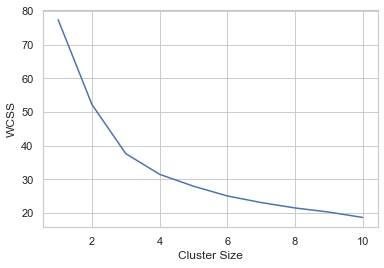

In [19]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
pd.DataFrame(wcss, index=range(1, 11)).plot(legend=False).set(xlabel="Cluster Size", ylabel="WCSS")

Use the elbow point of k=3 to predict and assign the clusters to training dataset.

In [20]:
kmeans = KMeans(n_clusters=3,init='k-means++')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

X['cluster'] = y_kmeans
clusters = X.groupby('cluster').agg('mean')
clusters

,Danceability,Energy,Acousticness,Valence
cluster,,,,
0,0.594,0.457,0.640,0.434
1,0.601,0.672,0.117,0.331
2,0.733,0.749,0.149,0.729


Visualize the clusters to obtain a better understanding of them.

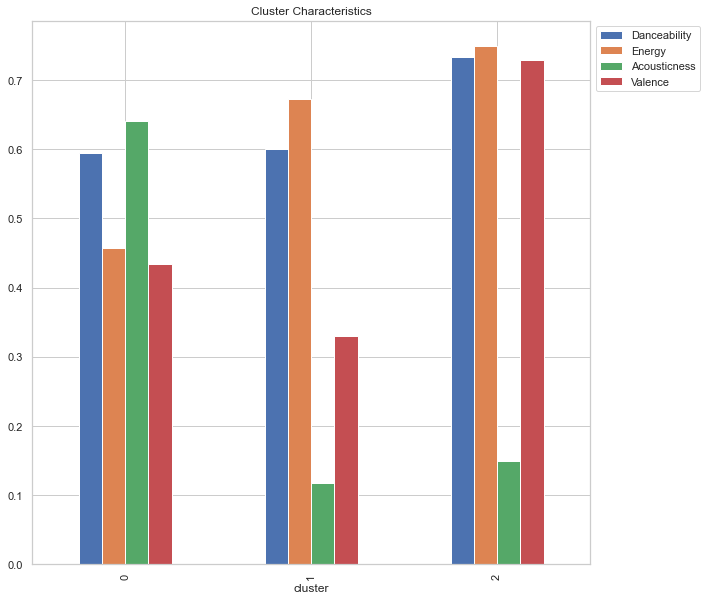

In [21]:
clusters.plot(kind='bar', figsize=(10,10))
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

After using the same clustering method and hyperparameters, we can observe the differences in Spotify's and Youtube's top 500 songs.
Like Spotify's data, Cluster 0's songs are high enery, high dancing, and high valence signifying happy pop songs. Cluster 1's songs are lower in energy and dancing but much higher in acousticness signifiying the country/indie/pop rock songs. Cluster 2's songs are high in energy and high in dancing by lower in valence signifying the more emotional but intense songs. 

It seems that Youtube and Spotify contain the same 3 general groups of popular songs. This is intuitive as the more popular the song is on Spotify, the more popular it will be on Youtube and vice-versa.

# Song Reccomendation

Once again, create our X training data using the dataframe. Figure out the optimal number of clusters for assigning clusters to all of the songs.

[Text(0.5, 0, 'Cluster Size'), Text(0, 0.5, 'WCSS')]

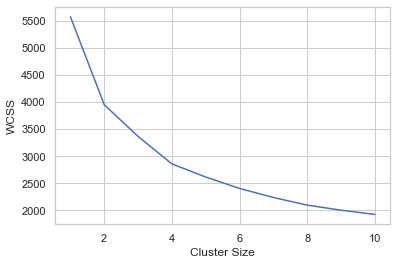

In [22]:
X = df2.drop(columns=['Stream', 'Views', 'Key'])
X[['Loudness', 'Tempo']] = scaler.fit_transform(X[['Loudness', 'Tempo']])

wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
pd.DataFrame(wcss, index=range(1, 11)).plot(legend=False).set(xlabel="Cluster Size", ylabel="WCSS")

Use the elbow point of k=4 to assign our clusters.

In [23]:
kmeans = KMeans(n_clusters=4,init='k-means++')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Map the k-means predictions back to the originl dataframe.

In [24]:
from sklearn.metrics.pairwise import euclidean_distances

df = df.drop(columns=['Album', 'Album_type', 'Views', 'Likes', 'Stream'])
df['Cluster'] = y_kmeans
df

,Artist,Track,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Cluster
0,Gorillaz,Feel Good Inc.,0.818,0.705,6.000,-6.679,0.177,0.008,0.002,0.613,0.772,138.559,2
1,Gorillaz,Rhinestone Eyes,0.676,0.703,8.000,-5.815,0.030,0.087,0.001,0.046,0.852,92.761,2
3,Gorillaz,On Melancholy Hill,0.689,0.739,2.000,-5.810,0.026,0.000,0.509,0.064,0.578,120.423,1
4,Gorillaz,Clint Eastwood,0.663,0.694,10.000,-8.627,0.171,0.025,0.000,0.070,0.525,167.953,1
5,Gorillaz,DARE,0.760,0.891,11.000,-5.852,0.037,0.023,0.087,0.298,0.966,120.264,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20713,SICK LEGEND,JUST DANCE HARDSTYLE,0.582,0.926,5.000,-6.344,0.033,0.448,0.000,0.084,0.658,90.002,2
20714,SICK LEGEND,SET FIRE TO THE RAIN HARDSTYLE,0.531,0.936,4.000,-1.786,0.137,0.028,0.000,0.092,0.657,174.869,2
20715,SICK LEGEND,OUTSIDE HARDSTYLE SPED UP,0.443,0.830,4.000,-4.679,0.065,0.024,0.000,0.154,0.419,168.388,1
20716,SICK LEGEND,ONLY GIRL HARDSTYLE,0.417,0.767,9.000,-4.004,0.419,0.356,0.018,0.108,0.539,155.378,1


This is our song reccomend function. It goes as follows:
1. Locate the song in the original dataframe.
2. Create a new dataframe based on what cluster that song was assigned to
3. Calculate the distance column which is the eucledian distance from the passed in song to every song in the dataframe
4. Sort the dataframe based on distance and return the top 10 songs with the shortest distance

In [25]:
def reccomend(song, artist):
    
    song_row = df.loc[(df['Track'] == song) & (df['Artist'] == artist)].values.tolist()
    song_row = song_row[0]
    cluster_df = df[df['Cluster'] == song_row[-1]].copy()
    
    cluster_df['Distance'] = cluster_df.apply(lambda row : euclidean_distances(np.array([song_row[2:]]), np.array([row.tolist()[2:]]))[0][0], axis = 1)
    cluster_df = cluster_df.sort_values('Distance', ascending=True)
    display(cluster_df[['Artist', 'Track', 'Distance']][1:11])

In [26]:
reccomend('Me Porto Bonito', 'Chencho Corleone')

,Artist,Track,Distance
18174,Jubin Nautiyal,Dil Galti Kar Baitha Hai,0.339
9742,Wisin,"Escápate Conmigo (feat. Ozuna, Bad Bunny, De L...",0.398
19064,Bad Omens,CONCRETE JUNGLE,0.428
2504,3 Doors Down,Let Me Go,0.508
8146,The Strokes,Ode To The Mets,0.703
18684,070 Shake,Escapism. - Slowed Down,0.853
6044,Mos Def,Sunshine,0.922
4641,Kid Rock,Devil Without a Cause,1.017
18041,Rels B,La Última Canción,1.060
4280,Keyshia Cole,Shoulda Let You Go,1.077


# Conclusion

After looking at the data from our 3 clusters in the top 500 Spotify vs the top 500 Youtube songs, it is evident that they share very similar characteristics. The 3 types of songs that performed well on one of the platforms, similarly performed well on the other, and which is what we could have predicted. 

There seems to be a mutual favoritism towards high energy and high danceability songs as those two metrics were on average high for popular songs. Moreover, music listeners tend enjoy both happy and sad music (more often picking happier than sadder). And lastly, there seems to be a substantial niche of acoustic music listeners as one of the clusters was predominantly acoustic. 

One reason our data could be skewed is that some of these metrics (energy, dancibility, valence in particular) are Spotify's attempt to objectively assign values to subjective quantities. A song that is dancible to one person may not be to another. So, the ranking of these metrics will not hold true for everyone.

Since there isn't a direct relationship between the song metrics and success, there is not much we can do. But one way to improve our Spotify Youtube reccomedation would be to have access to the songs genre, so we can better reccomend songs that sound similar and from that genre.

Thanks for the fun quarter!